In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import signalz
from signalz.misc import check_type_or_raise
from signalz.generators.gaussian_white_noise import gaussian_white_noise
from signalz.generators.uniform_white_noise import uniform_white_noise
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import math

2023-01-12 15:57:51.391443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# generate red-noise time series
# source: https://github.com/matousc89/signalz/blob/master/signalz/generators/brownian_noise.py
def brownian_noise(n, leak=0., start=0, std=1., source="gaussian"):
    # check inputs
    check_type_or_raise(n, int, "n")
    check_type_or_raise(leak, float, "leak")
    if not 0. <= leak < 1:
        raise ValueError("Leak must be between 0. and 1.")
    # generate white noise
    if source == "gaussian":
        x = np.random.normal(0, std, n)
    elif source == "uniform":
        x = np.random.uniform(-std / 2., std / 2., n)
    else:
        raise ValueError("Source must be gaussian or uniform")
    # add offset
    x[0] = start
    # integrate the white noise
    for i in range(1, n):
        x[i] += x[i - 1] * (1 - leak)
    return x

In [3]:
def findkernel(temp_grad, F_flux, time_interval, N_points, tau, m_sample, kernel_size, pre_kernel, tspan, n_epoch):

    # build single layer conv1d 
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
    
    input_series = keras.layers.Input(temp_grad.shape[1:])
    output_series = keras.layers.Conv1D(filters=1, padding='valid', kernel_size=kernel_size, strides=1, activation='linear', input_shape=(temp_grad.shape[1:]))(input_series)
    model = keras.Model(input_series, output_series)
    weights = model.get_weights() # store the initial random weights
    new_weights = [np.random.randn(*w.shape) for w in weights]
    adam = keras.optimizers.Adam(epsilon = 1e-02) #adjust epsilon
    model.compile(
        optimizer=adam,
        loss= 'mean_squared_error',
        metrics=['mean_squared_error'])
    #model.summary()
    
    # split train and test sets
    X_train, X_rem, y_train, y_rem = train_test_split(temp_grad, F_flux, train_size=0.8)
    
    # train the model
    history = model.fit(X_train, y_train, epochs=n_epoch, validation_data=(X_rem, y_rem), callbacks=[callback])
    val_loss = history.history['val_loss']
    
    # get the kernel
    conv_kernel = model.weights[0][:,0,0]
    a = tf.constant(conv_kernel)
    conv_kernel = a.numpy()
    conv_kernel = conv_kernel[::-1]
    
    # reset random initial weights
    model.set_weights(new_weights)
    
    return (conv_kernel, val_loss)

In [17]:
time_interval = 6 # corresponding time interval duration in say days
N_points = 362 # red-noise vector length
tau = 0.2
m_sample = 10; 
kernel_size = 40 # truncate the kernel to include some small number of points since we are assuming it decays with time
n_kernel = 50;
tspan = np.linspace(0, time_interval, N_points)
pre_kernel = np.exp(-tspan/tau) # define pre-defined kernel
n_epoch = 8000;

pre_kernel = pre_kernel[:kernel_size] # now kernel has a smaller number of points relative to the Tgradient time series
tspan_kernel = tspan[:kernel_size]
tspan_convolved = tspan[len(pre_kernel)-1:] # the correct way of assigning time to the convolved timeseries

#import data
grad_sst = np.load('/Users/liyiran/Desktop/eddymemory/grad_SST.npy')
heat_flux = np.load('/Users/liyiran/Desktop/eddymemory/heat_flux.npy')

#split data evenly for 11 years
#for training model: X is G_sst(shape: (11,362,1)), Y is H_flux(shape:(11,362,1))
grad_sst = grad_sst[0:3982]
print(grad_sst)
G_sst = np.zeros((11,362,1))
for i in range(11):
    G_sst[i,:,0] = np.split(grad_sst,11)[i]

heat_flux = heat_flux[0:3982]
H_flux = np.zeros((10,362-kernel_size+1,1))
for i in range(11):
    H_flux[i,:,0] = np.split(heat_flux,11)[i][kernel_size-1:362]

[4.11693087e-06 3.83654697e-06 3.65302438e-06 ... 3.74384775e-06
 3.51566611e-06 3.31605374e-06]


[[[4.11693087e-06]
  [3.83654697e-06]
  [3.65302438e-06]
  ...
  [4.78190083e-06]
  [4.64982205e-06]
  [4.31416910e-06]]

 [[4.19575339e-06]
  [3.75893430e-06]
  [3.42184731e-06]
  ...
  [5.52600997e-06]
  [5.38413391e-06]
  [5.29619452e-06]]

 [[5.20789577e-06]
  [5.28982061e-06]
  [5.48629144e-06]
  ...
  [3.79993863e-06]
  [3.76521498e-06]
  [3.82284281e-06]]

 ...

 [[4.65231988e-06]
  [4.25576228e-06]
  [4.09606024e-06]
  ...
  [6.96857577e-06]
  [6.71100402e-06]
  [7.00076396e-06]]

 [[7.12848325e-06]
  [7.08171513e-06]
  [6.90781514e-06]
  ...
  [3.46713129e-06]
  [3.70944808e-06]
  [3.99323200e-06]]

 [[4.39834817e-06]
  [4.11430182e-06]
  [3.87296218e-06]
  ...
  [3.74384775e-06]
  [3.51566611e-06]
  [3.31605374e-06]]]
[[[-0.28119592]
  [-0.24326943]
  [-0.24100464]
  ...
  [ 0.03090719]
  [ 0.01002951]
  [ 0.00582427]]

 [[ 0.18865762]
  [ 0.1810804 ]
  [ 0.15990224]
  ...
  [ 0.02170304]
  [ 0.01407136]
  [ 0.00711587]]

 [[ 0.03578954]
  [ 0.05434851]
  [ 0.07580744]
  ...


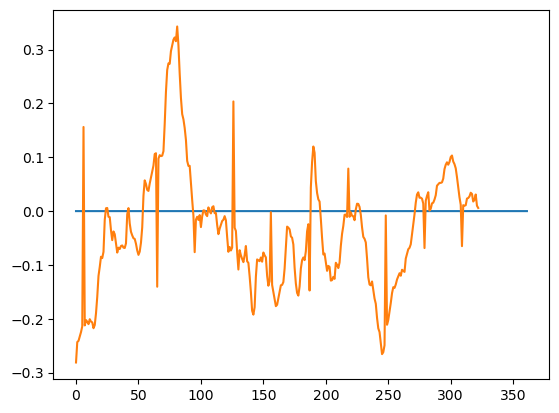

In [16]:
print(G_sst)
print(H_flux)

plt.plot(G_sst[0,:])
plt.plot(H_flux[0,:])

In [7]:
#run the model
K_kernel = np.zeros((n_kernel,kernel_size))
L_val = np.zeros((n_kernel, n_epoch))
temp_grad = np.zeros((m_sample,N_points,1))
F_flux = np.zeros((m_sample,N_points - kernel_size + 1,1))


for j in range(n_kernel):
    temp_grad = G_sst
    F_flux = H_flux   
    #for i in range(m_sample):
        #temp_grad[i,:,0] = brownian_noise(N_points, leak=0.1, start=0, std=1, source='gaussian')
        #F_flux[i,:,0] = np.convolve(pre_kernel, temp_grad[i,:,0], mode='valid')
    # save kernel
    K_kernel[j,:] = findkernel(temp_grad,F_flux,time_interval,N_points,tau,m_sample,kernel_size,pre_kernel,tspan,n_epoch)[0]    

Epoch 1/8000


2023-01-12 15:58:44.464315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 607ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 2/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 3/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 4/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 1/8000
1/1 [==============================] - 1s 598ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 2/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 3/8000
1/1 [===========================

Epoch 48/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 49/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 50/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 51/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 52/8000
1/1 [==============================] - 0s 66ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 53/8000
1/1 [==============================] - 0s 57ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 54/8000
1/1 [=========

1/1 [==============================] - 1s 515ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 3/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 4/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 5/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 6/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 7/8000
1/1 [============================

Epoch 52/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 53/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 54/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 55/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 56/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 57/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 58/8000
1/1 [=========

1/1 [==============================] - 0s 39ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 103/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 104/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 1/8000
1/1 [==============================] - 0s 449ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 3/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 4/8000
1/1 [========================

Epoch 49/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 50/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 51/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 52/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 53/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 54/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 55/8000
1/1 [=========

1/1 [==============================] - 0s 32ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 100/8000
1/1 [==============================] - 0s 30ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 101/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 102/8000
1/1 [==============================] - 0s 30ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 103/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 104/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 105/8000
1/1 [=================

Epoch 13/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 14/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 15/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 16/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 17/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 18/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 19/8000
1/1 [=========

1/1 [==============================] - 0s 42ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 64/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 65/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 66/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 67/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 68/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 69/8000
1/1 [=======================

Epoch 10/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 11/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 12/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 13/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 14/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 15/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 16/8000
1/1 [=========

1/1 [==============================] - 0s 39ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 23/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 24/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 25/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 26/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 27/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 28/8000
1/1 [=======================

Epoch 73/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 74/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 75/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 76/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 77/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 78/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 79/8000
1/1 [=========

1/1 [==============================] - 0s 38ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 34/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 35/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 36/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 37/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 38/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 39/8000
1/1 [=======================

Epoch 84/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 85/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 86/8000
1/1 [==============================] - 0s 30ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 87/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 88/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 89/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 90/8000
1/1 [=========

1/1 [==============================] - 0s 142ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 42/8000
1/1 [==============================] - 0s 122ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 43/8000
1/1 [==============================] - 0s 85ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 44/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 45/8000
1/1 [==============================] - 0s 176ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 46/8000
1/1 [==============================] - 0s 113ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 47/8000
1/1 [===================

1/1 [==============================] - 0s 37ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 92/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 93/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 94/8000
1/1 [==============================] - 0s 30ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 95/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 96/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 97/8000
1/1 [=======================

Epoch 34/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 35/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 36/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 37/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 38/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 39/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 40/8000
1/1 [=========

1/1 [==============================] - 0s 62ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 44/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 45/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 46/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 47/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 48/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 49/8000
1/1 [=======================

1/1 [==============================] - 0s 45ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 94/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 95/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 96/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 97/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 98/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 99/8000
1/1 [=======================

Epoch 38/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 39/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 40/8000
1/1 [==============================] - 0s 29ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 41/8000
1/1 [==============================] - 0s 30ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 42/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 43/8000
1/1 [==============================] - 0s 28ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 44/8000
1/1 [=========

1/1 [==============================] - 0s 35ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 89/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 90/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 91/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 92/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 93/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 94/8000
1/1 [=======================

Epoch 17/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 18/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 19/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 20/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 21/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 22/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 23/8000
1/1 [=========

1/1 [==============================] - 0s 33ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 68/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 69/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 70/8000
1/1 [==============================] - 0s 29ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 71/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 72/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 73/8000
1/1 [=======================

Epoch 10/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 11/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 12/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 13/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 14/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 15/8000
1/1 [==============================] - 0s 29ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 16/8000
1/1 [=========

1/1 [==============================] - 0s 35ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 61/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 62/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 63/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 64/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 65/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 66/8000
1/1 [=======================

Epoch 36/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 37/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 38/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 39/8000
1/1 [==============================] - 0s 29ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 40/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 41/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 42/8000
1/1 [=========

1/1 [==============================] - 0s 36ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 12/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 13/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 14/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 15/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 16/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 17/8000
1/1 [=======================

Epoch 17/8000
1/1 [==============================] - 0s 56ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 18/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 19/8000
1/1 [==============================] - 0s 32ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 20/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 21/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 22/8000
1/1 [==============================] - 0s 29ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 23/8000
1/1 [=========

1/1 [==============================] - 0s 34ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 29/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 30/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 31/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 32/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 33/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 34/8000
1/1 [=======================

Epoch 79/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 80/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 81/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 82/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 83/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 84/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 85/8000
1/1 [=========

1/1 [==============================] - 0s 54ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 29/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 30/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 31/8000
1/1 [==============================] - 0s 33ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 32/8000
1/1 [==============================] - 0s 31ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 33/8000
1/1 [==============================] - 0s 30ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 34/8000
1/1 [=======================

Epoch 79/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 80/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 81/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 82/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 83/8000
1/1 [==============================] - 0s 103ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 84/8000
1/1 [==============================] - 0s 74ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 85/8000
1/1 [========

1/1 [==============================] - 0s 37ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 27/8000
1/1 [==============================] - 0s 35ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 28/8000
1/1 [==============================] - 0s 60ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 29/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 30/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 31/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 32/8000
1/1 [=======================

Epoch 20/8000
1/1 [==============================] - 0s 61ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 21/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 22/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 23/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 24/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 25/8000
1/1 [==============================] - 0s 68ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 26/8000
1/1 [=========

1/1 [==============================] - 0s 64ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 71/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 72/8000
1/1 [==============================] - 0s 68ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 73/8000
1/1 [==============================] - 0s 64ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 74/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 75/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 76/8000
1/1 [=======================

Epoch 27/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 28/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 29/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 30/8000
1/1 [==============================] - 0s 57ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 31/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 32/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 33/8000
1/1 [=========

1/1 [==============================] - 0s 53ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 25/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 26/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 27/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 28/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 29/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 30/8000
1/1 [=======================

Epoch 33/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 34/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 35/8000
1/1 [==============================] - 0s 61ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 36/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 37/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 38/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 39/8000
1/1 [=========

1/1 [==============================] - 0s 58ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 84/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 85/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 86/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 87/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 88/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 89/8000
1/1 [=======================

1/1 [==============================] - 0s 58ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 24/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 25/8000
1/1 [==============================] - 0s 57ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 26/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 27/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 28/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 29/8000
1/1 [=======================

Epoch 74/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 75/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 76/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 77/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 78/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 79/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 80/8000
1/1 [=========

1/1 [==============================] - 0s 67ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 21/8000
1/1 [==============================] - 0s 61ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 22/8000
1/1 [==============================] - 0s 70ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 23/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 24/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 25/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 26/8000
1/1 [=======================

Epoch 71/8000
1/1 [==============================] - 0s 81ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 72/8000
1/1 [==============================] - 0s 73ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 73/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 74/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 75/8000
1/1 [==============================] - 0s 187ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 76/8000
1/1 [==============================] - 0s 130ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 77/8000
1/1 [=======

1/1 [==============================] - 0s 50ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 16/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 17/8000
1/1 [==============================] - 0s 143ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 18/8000
1/1 [==============================] - 0s 66ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 19/8000
1/1 [==============================] - 0s 64ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 20/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 21/8000
1/1 [======================

1/1 [==============================] - 0s 90ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 66/8000
1/1 [==============================] - 0s 74ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 67/8000
1/1 [==============================] - 0s 93ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 68/8000
1/1 [==============================] - 0s 91ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 69/8000
1/1 [==============================] - 0s 84ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 70/8000
1/1 [==============================] - 0s 59ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 71/8000
1/1 [=======================

Epoch 18/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 19/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 20/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 21/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 22/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 23/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 24/8000
1/1 [=========

1/1 [==============================] - 0s 95ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 69/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 70/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 71/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 72/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 73/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 74/8000
1/1 [=======================

Epoch 24/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 25/8000
1/1 [==============================] - 0s 62ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 26/8000
1/1 [==============================] - 0s 62ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 27/8000
1/1 [==============================] - 0s 76ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 28/8000
1/1 [==============================] - 0s 83ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 29/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 30/8000
1/1 [=========

1/1 [==============================] - 0s 54ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 75/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 76/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 77/8000
1/1 [==============================] - 0s 61ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 78/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 79/8000
1/1 [==============================] - 0s 70ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 80/8000
1/1 [=======================

Epoch 18/8000
1/1 [==============================] - 0s 75ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 19/8000
1/1 [==============================] - 0s 59ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 20/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 21/8000
1/1 [==============================] - 0s 60ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 22/8000
1/1 [==============================] - 0s 71ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 23/8000
1/1 [==============================] - 0s 94ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 24/8000
1/1 [=========

1/1 [==============================] - 0s 51ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 69/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 70/8000
1/1 [==============================] - 0s 70ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 71/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 72/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 73/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 74/8000
1/1 [=======================

Epoch 27/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 28/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 29/8000
1/1 [==============================] - 0s 62ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 30/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 31/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 32/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 33/8000
1/1 [=========

1/1 [==============================] - 0s 41ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 78/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 79/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 80/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 81/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 82/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 83/8000
1/1 [=======================

Epoch 19/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 20/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 21/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 22/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 23/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 24/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 25/8000
1/1 [=========

1/1 [==============================] - 0s 51ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 70/8000
1/1 [==============================] - 0s 66ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 71/8000
1/1 [==============================] - 0s 57ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 72/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 73/8000
1/1 [==============================] - 0s 62ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 74/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 75/8000
1/1 [=======================

Epoch 13/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 14/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 15/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 16/8000
1/1 [==============================] - 0s 54ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 17/8000
1/1 [==============================] - 0s 53ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 18/8000
1/1 [==============================] - 0s 61ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 19/8000
1/1 [=========

1/1 [==============================] - 0s 60ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 18/8000
1/1 [==============================] - 0s 71ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 19/8000
1/1 [==============================] - 0s 76ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 20/8000
1/1 [==============================] - 0s 51ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 21/8000
1/1 [==============================] - 0s 52ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 22/8000
1/1 [==============================] - 0s 61ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 23/8000
1/1 [=======================

Epoch 68/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 69/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 70/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 71/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 72/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 73/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 74/8000
1/1 [=========

1/1 [==============================] - 0s 40ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 10/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 11/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 12/8000
1/1 [==============================] - 0s 42ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 13/8000
1/1 [==============================] - 0s 37ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 14/8000
1/1 [==============================] - 0s 36ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 15/8000
1/1 [=======================

Epoch 60/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 61/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 62/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 63/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 64/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 65/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 66/8000
1/1 [=========

1/1 [==============================] - 0s 487ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 2/8000
1/1 [==============================] - 0s 34ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 3/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 4/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 5/8000
1/1 [==============================] - 0s 38ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 6/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 7/8000
1/1 [============================

Epoch 33/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 34/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 35/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 36/8000
1/1 [==============================] - 0s 50ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 37/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 38/8000
1/1 [==============================] - 0s 48ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 39/8000
1/1 [=========

1/1 [==============================] - 0s 43ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 84/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 85/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 86/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 87/8000
1/1 [==============================] - 0s 40ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 88/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 89/8000
1/1 [=======================

Epoch 16/8000
1/1 [==============================] - 0s 55ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 17/8000
1/1 [==============================] - 0s 49ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 18/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 19/8000
1/1 [==============================] - 0s 39ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 20/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 21/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 22/8000
1/1 [=========

1/1 [==============================] - 0s 46ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 67/8000
1/1 [==============================] - 0s 46ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 68/8000
1/1 [==============================] - 0s 41ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 69/8000
1/1 [==============================] - 0s 47ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 70/8000
1/1 [==============================] - 0s 45ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 71/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 72/8000
1/1 [=======================

Epoch 12/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 13/8000
1/1 [==============================] - 0s 66ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 14/8000
1/1 [==============================] - 0s 66ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 15/8000
1/1 [==============================] - 0s 91ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 16/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 17/8000
1/1 [==============================] - 0s 58ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 18/8000
1/1 [=========

1/1 [==============================] - 0s 46ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 35/8000
1/1 [==============================] - 0s 44ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 36/8000
1/1 [==============================] - 0s 43ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 37/8000
1/1 [==============================] - 0s 63ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 38/8000
1/1 [==============================] - 0s 67ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0141 - val_mean_squared_error: 0.0141


In [8]:
print(K_kernel.shape)

(50, 40)


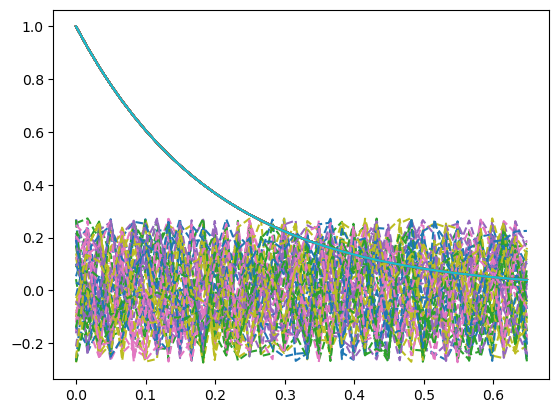

In [9]:
for k in range(n_kernel):
    plt.plot(tspan[:kernel_size], K_kernel[k,:],'--')

    plt.plot(tspan[:kernel_size], pre_kernel[:kernel_size])

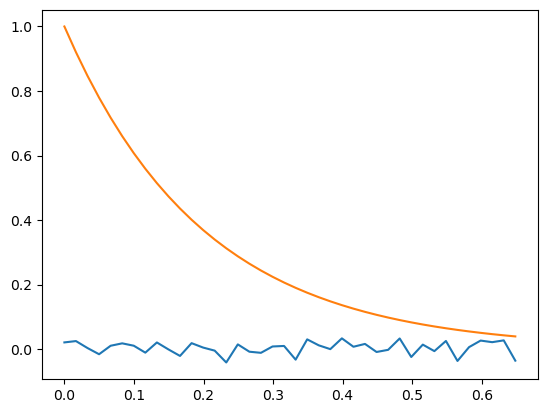

In [10]:
avg_kernel = np.mean(K_kernel[0:n_kernel,:], axis=0)
plt.plot(tspan[:kernel_size], avg_kernel)
plt.plot(tspan[:kernel_size], pre_kernel[:kernel_size])